In [ ]:
#http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
import numpy as np
import pandas as pd
import datetime
import os
import json
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import base64
from PIL import Image
import io
import pymongo

In [ ]:
def read_image_string(file_name):
    image_string = None
    with open(file_name, "rb") as image:
        image_string = base64.b64encode(image.read())
    return image_string

def read_image_stats(file_name):
    image_obj = Image.open(file_name)
    image_size = image_obj.size
    image_mode = image_obj.mode
    return image_size[0],image_size[1],image_mode
    
def image_ingest_mongodb(image_fld_df,
                        mongodb_url, 
                        db_name, 
                        collection_name):
    process_success = True
    try:
        myclient = pymongo.MongoClient(mongodb_url)
        db = myclient[db_name]
        Collection = db[collection_name]
        file_data = image_fld_df.to_dict(orient='records')
        if isinstance(file_data, list):
            Collection.insert_many(file_data)
        else:
            Collection.insert_one(file_data)
    except Exception as err:
        print(err)
        process_success = False
    return process_success
    
def read_image_folder(dir_name):
    image_dict = dict()
    images_fld_df = pd.DataFrame()
    if dir_name:
        files = [dir_name + "/" + f for f in os.listdir(dir_name) if not f.startswith('.')]
        count_images = 0
        for image_file in files:
            image_string = read_image_string(image_file)
            image_size_x,image_size_y,image_mode = read_image_stats(image_file)
            image_dict['image_string'] = image_string
            image_dict['size_x'] = image_size_x
            image_dict['size_y'] = image_size_y
            image_dict['mode'] = image_mode
            image_df = pd.DataFrame(image_dict,index=[count_images])
            count_images += 1
            if images_fld_df.shape[0]>0:
                images_fld_df = pd.concat([images_fld_df, image_df],ignore_index=False)
            else:
                images_fld_df = image_df
            image_dict = dict()
            image_df = None
    return images_fld_df

In [ ]:
def test():
    images_fld_df_0 = read_image_folder('/content/EnglishHnd/Sample001')
    ######
    images_fld_df_1 = read_image_folder('/content/EnglishHnd/Sample002')
    return images_fld_df_0, images_fld_df_1 

In [ ]:
images_fld_df_0, images_fld_df_1 = test()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
import keras.optimizers

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [ ]:
def get_data(images_fld_df,labels,label,fx_resize,fy_resize):
    data = []
    for index,document in images_fld_df.iterrows():
        class_num = labels.index(label)
        try:
            jpg_original = base64.b64decode(document['image_string'])
            jpg_as_np = np.frombuffer(jpg_original, dtype=np.uint8)
            img = cv2.imdecode(jpg_as_np, flags=1)
            img = cv2.resize(img, (0, 0), fx = fx_resize, fy = fy_resize)
            data.append([img, class_num])
        except Exception as e:
            print(e)
    return np.array(data)

In [ ]:
labels = ['0', '1']
fx_resize = 0.1
fy_resize = 0.1

train_0 = get_data(images_fld_df_0,labels,'0',fx_resize,fy_resize)
train_1 = get_data(images_fld_df_1,labels,'1',fx_resize,fy_resize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


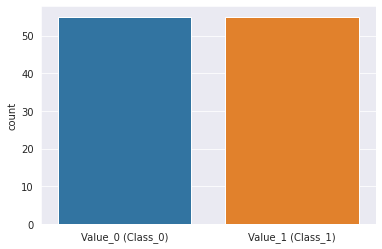

In [ ]:
train = np.concatenate([train_0,train_1])

l = []
for i in train:
    if(i[1] == 0):
        l.append("Value_0 (Class_0)")
    else:
        l.append("Value_1 (Class_1)")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, '1')

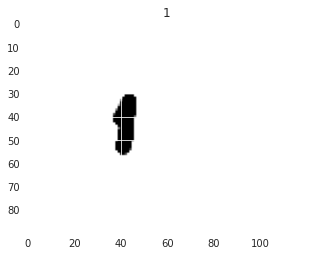

In [16]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

Text(0.5, 1.0, '0')

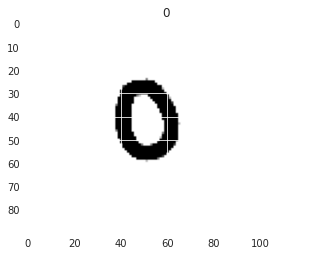

In [17]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in train:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

img_size = [120,90]

x_train.reshape(-1, img_size[0], img_size[1], 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size[0], img_size[1], 1)
y_val = np.array(y_val)

In [ ]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size[0], img_size[1],3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 90, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 45, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 11, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 11, 64)        0

In [ ]:
from keras.optimizers import adam_v2
epochs = 20
opt = adam_v2.Adam(learning_rate=0.001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs = epochs , validation_data = (x_val, y_val))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


4/4 [==============================] - 3s 572ms/step - loss: 2.0399 - accuracy: 0.4364 - val_loss: 0.6984 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 2s 518ms/step - loss: 0.6979 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 2s 491ms/step - loss: 0.6882 - accuracy: 0.6273 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 2s 497ms/step - loss: 0.6848 - accuracy: 0.5000 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 2s 489ms/step - loss: 0.6812 - accuracy: 0.5273 - val_loss: 0.6666 - val_accuracy: 0.5000
Epoch 6/20
4/4 [==============================] - 2s 489ms/step - loss: 0.6612 - accuracy: 0.5727 - val_loss: 0.6365 - val_accuracy: 0.8727
Epoch 7/20
4/4 [==============================] - 2s 489ms/step - loss: 0.6234 - accuracy: 0.8273 - val_loss: 0.5781 - val_accuracy: 0.8727
Epoch 8/20
4/4 [===============

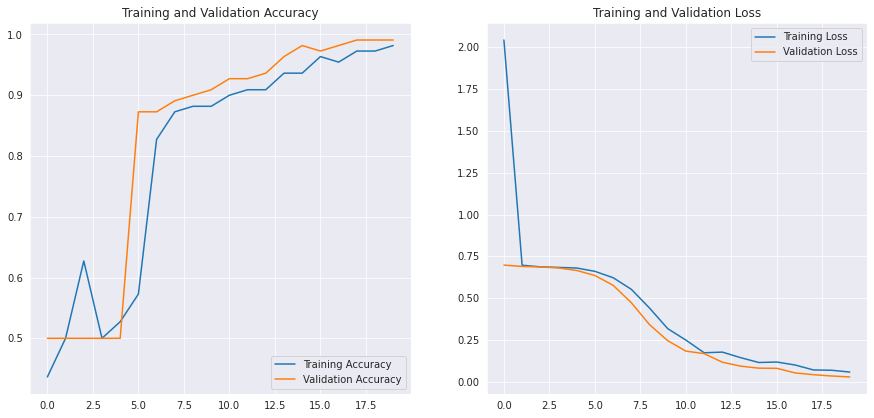

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = history.model.predict(x_val)
predictions = predictions[:110].reshape(-1,2)
prediction_flags = [1 if x[1]>=x[0] else 0 for x in predictions]
print(classification_report(y_val, prediction_flags, target_names = ['Value_0 (Class_0)','Value_1 (Class_1)']))

                   precision    recall  f1-score   support

Value_0 (Class_0)       1.00      0.98      0.99        55
Value_1 (Class_1)       0.98      1.00      0.99        55

         accuracy                           0.99       110
        macro avg       0.99      0.99      0.99       110
     weighted avg       0.99      0.99      0.99       110



In [ ]:
print(predictions)

[[9.9999547e-01 4.4990243e-06]
 [9.8785186e-01 1.2148097e-02]
 [9.9887079e-01 1.1291950e-03]
 [9.9998486e-01 1.5132971e-05]
 [9.9998367e-01 1.6301197e-05]
 [9.9540734e-01 4.5926953e-03]
 [9.9999166e-01 8.3856276e-06]
 [9.4473433e-01 5.5265687e-02]
 [9.0352976e-01 9.6470229e-02]
 [9.9998748e-01 1.2474221e-05]
 [9.9988019e-01 1.1980221e-04]
 [9.9998558e-01 1.4429628e-05]
 [9.9997246e-01 2.7581975e-05]
 [9.9993992e-01 6.0104710e-05]
 [9.9999547e-01 4.5623710e-06]
 [9.9868006e-01 1.3199742e-03]
 [9.9993122e-01 6.8775204e-05]
 [9.9999583e-01 4.1520316e-06]
 [9.9995947e-01 4.0563467e-05]
 [9.9814343e-01 1.8565606e-03]
 [9.6521384e-01 3.4786168e-02]
 [9.9993813e-01 6.1832769e-05]
 [9.2618454e-01 7.3815502e-02]
 [2.8410435e-01 7.1589571e-01]
 [9.9992609e-01 7.3851523e-05]
 [9.9826980e-01 1.7302411e-03]
 [9.8441941e-01 1.5580553e-02]
 [9.9994659e-01 5.3347721e-05]
 [9.9986255e-01 1.3740375e-04]
 [9.9994671e-01 5.3264714e-05]
 [9.9992609e-01 7.3906478e-05]
 [9.6818417e-01 3.1815790e-02]
 [9.7823